In [1]:
%matplotlib inline
import pandas as pd
import time
import sys
from pathlib import Path
from pprint import pprint
import numpy as np
from operator import add
from warnings import simplefilter
import datetime
from tqdm.notebook import tqdm

pd.options.mode.chained_assignment = None #comment if you want the warning message

In [2]:
def arffToDataframe(arff_file, normalize=False):
    from scipy.io import arff
    import pandas as pd
    data = arff.loadarff(arff_file)
    df = pd.DataFrame(data[0])
    df_int = bytesToInt(df)
    if normalize:
        df_int= normalizeDataframe(df_int, normalize)
    return df_int

def bytesToInt(df):
    import pandas as pd
    import numpy as np
    for column in df:
        df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0).astype(np.int64)
    return df

In [3]:
from operator import add
import warnings
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import copy
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#input file name
arff_file = "../mendeley.arff"

#name of the column defining the label
label_name = 'CLASS_LABEL'

# These are the features used by the classifiers
features = pd.Index(["NumDots",
                     "SubdomainLevel",
                     "PathLevel",
                     "UrlLength",
                     "NumDash",
                     "NumDashInHostname",
                     "AtSymbol",
                     "TildeSymbol",
                     "NumUnderscore",
                     "NumPercent",
                     "NumQueryComponents",
                     "NumAmpersand",
                     "NumHash",
                     "NumNumericChars",
                     "NoHttps",
                     "RandomString",
                     "IpAddress",
                     "DomainInSubdomains",
                     "DomainInPaths",
                     "HttpsInHostname",
                     "HostnameLength",
                     "PathLength",
                     "QueryLength",
                     "DoubleSlashInPath",
                     "NumSensitiveWords",
                     "EmbeddedBrandName",
                     "PctExtHyperlinks",
                     "PctExtResourceUrls",
                     "ExtFavicon",
                     "InsecureForms",
                     "RelativeFormAction",
                     "ExtFormAction",
                     "AbnormalFormAction",
                     "PctNullSelfRedirectHyperlinks",
                     "FrequentDomainNameMismatch",
                     "FakeLinkInStatusBar",
                     "RightClickDisabled",
                     "PopUpWindow",
                     "SubmitInfoToEmail",
                     "IframeOrFrame",
                     "MissingTitle",
                     "ImagesOnlyInForm",
                     "SubdomainLevelRT",
                     "UrlLengthRT",
                     "PctExtResourceUrlsRT",
                     "AbnormalExtFormActionR",
                     "ExtMetaScriptLinkRT",
                     "PctExtNullSelfRedirectHyperlinksRT"
                    ])

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
import numpy as np
import copy

#### Accuracy
from collections import defaultdict
clean_accs = defaultdict(lambda: [])
poison_accs = defaultdict(lambda: [])

performance = []

In [4]:
print("Start Time: {}".format(datetime.datetime.now()))
begin_time = time.time()

Start Time: 2023-11-27 13:16:25.731346


In [5]:
trials = 30

# You do the whole process again from start (this means that "test" will change)
for reps in tqdm(range(trials)):
    # Set the flipping ratios for malicious and benign samples
    flip_ratios_mal = [0.1,0.2]
    flip_ratios_ben = [0.1,0.2]

    # Set the fixed test size
    test_size = 2000

    # Set the training set sizes to try (e.g.: 0.5 of 8000 => 4000)
    train_sizes = [0.5, 0.8,1]

    # Load the dataset into a pandas dataframe
    df = arffToDataframe(arff_file)
    #print(df[label_name].value_counts())

    # Split the dataset into malicious and benign portions
    df_mal = df[df[label_name] == 1]
    df_ben = df[df[label_name] == 0]

    # Set a fixed random state for reproducibility (do I need this?)
    #For loop random states 
    random_state = reps
    
    # Extract test samples from both malicious and benign portions
    df_mal_test = df_mal.sample(n=test_size//2, random_state=random_state)
    df_ben_test = df_ben.sample(n=test_size//2, random_state=random_state)
    
    # Remove test samples from the remaining data
    df_mal_train = df_mal.drop(df_mal_test.index)
    df_ben_train = df_ben.drop(df_ben_test.index)
    
    test = pd.concat([df_mal_test, df_ben_test])
    #print(len(test))
    
    for train_size in train_sizes:
        # Calculate the number of samples for each class based on train_size
        num_mal_train = int(len(df_mal_train)*train_size)
        num_ben_train = int(len(df_ben_train)*train_size)
        #print(num_ben_train)
        #print(num_mal_train)
        
        # Extract train samples from both malicious and benign portions
        df_mal_train_sized = df_mal_train.sample(n=num_mal_train)
        df_ben_train_sized = df_ben_train.sample(n=num_ben_train)
        train = pd.concat([df_mal_train_sized, df_ben_train_sized])
        #print(len(train))
        # Create a deepcopy of the train dataset
        train_clean = copy.deepcopy(train)

        # Train a random forest classifier on the clean train dataset and test on the test set
        rf_clean = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                                min_weight_fraction_leaf=0.0, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                                bootstrap=True, oob_score=False, n_jobs=-1, random_state=0, 
                                                verbose=0, warm_start=False, class_weight=None)
        rf_clean.fit(train_clean.drop(label_name, axis=1), train_clean[label_name])
        clean_acc = rf_clean.score(test.drop(label_name, axis=1), test[label_name])
        #print(f"Train size: {train_size:.2f}")
        #print(f"Accuracy of clean RF: {clean_acc:.4f}")

        for flip_ratio_mal in flip_ratios_mal:
            
            # Extract "to_flip_mal" based on the flipping ratios:
            to_flip_mal = df_mal_train_sized.sample(frac=flip_ratio_mal)
            train_mal_clean = df_mal_train_sized.drop(to_flip_mal.index)
            to_flip_mal[label_name] = 0

            for flip_ratio_ben in flip_ratios_ben:
                
                # Extract "to_flip_ben" based on the flipping ratios:
                to_flip_ben = df_ben_train_sized.sample(frac=flip_ratio_ben)
                train_ben_clean = df_ben_train_sized.drop(to_flip_ben.index)
                to_flip_ben[label_name] = 1

                # Merge the flipped malicious and benign samples with the cleaned train dataset
                train_poisoned = pd.concat([to_flip_mal, to_flip_ben, train_mal_clean, train_ben_clean])
                
                
                # Train a random forest classifier on the poisoned train dataset and test on the test set
                rf_poison = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                                min_weight_fraction_leaf=0.0, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                                bootstrap=True, oob_score=False, n_jobs=-1, random_state=0, 
                                                verbose=0, warm_start=False, class_weight=None)
                rf_poison.fit(train_poisoned.drop(label_name, axis=1), train_poisoned[label_name])
                poisoned_acc = rf_poison.score(test.drop(label_name, axis=1), test[label_name])
                #print(f"Flip ratios: {flip_ratio_mal:.2f} (mal), {flip_ratio_ben:.2f} (ben)")
                #print(f"Accuracy of poisoned RF: {poisoned_acc:.4f}")
                
                # Calculate F1 score, false positives and false negatives
                y_true = test[label_name]
                y_pred_clean = rf_clean.predict(test.drop(label_name, axis=1))
                y_pred_poison = rf_poison.predict(test.drop(label_name, axis=1))

                f1_clean = f1_score(y_true, y_pred_clean)
                f1_poison = f1_score(y_true, y_pred_poison)
                #print(f1_poison)
                
                #calc recall
                recall_clean = recall_score(y_true, y_pred_clean)
                recall_poison = recall_score(y_true, y_pred_poison)
                #print(recall_poison)
                
                #calc precision
                precision_clean = precision_score(y_true, y_pred_clean)
                precision_poison = precision_score(y_true, y_pred_poison)
                #print(precision_poison)
                
                tn_clean, fp_clean, fn_clean, tp_clean = confusion_matrix(y_true, y_pred_clean).ravel()
                tn_poison, fp_poison, fn_poison, tp_poison = confusion_matrix(y_true, y_pred_poison).ravel()

                performance.append({
                    'train_size': train_size,
                    'flip_ratio_mal': flip_ratio_mal,
                    'flip_ratio_ben': flip_ratio_ben,
                    'clean_acc': clean_acc,
                    'poisoned_acc': poisoned_acc,
                    'f1_clean': f1_clean,
                    'f1_poison': f1_poison,
                    'fp_clean': fp_clean,
                    'fp_poison': fp_poison,
                    'fn_clean': fn_clean,
                    'fn_poison': fn_poison,
                    'recall_clean': recall_clean,
                    'recall_poison': recall_poison,
                    'precision_clean': precision_clean,
                    'precision_poison': precision_poison
                })

                #print(f"Performance: {performance[-1]}")

                # Repeat the process for different flipping ratios and training set sizes
                #print("\n")
                
                #######test######
                #Accuracy
                clean_accs[(train_size, flip_ratio_mal, flip_ratio_ben)].append(clean_acc)
                poison_accs[(train_size, flip_ratio_mal, flip_ratio_ben)].append(poisoned_acc)
                


  0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
print("End Time: {}".format(datetime.datetime.now()))

end_time = time.time()

total_time = end_time - begin_time

print("Runtime: {}s".format(total_time))

End Time: 2023-11-27 13:18:52.353478
Runtime: 146.6221318244934s


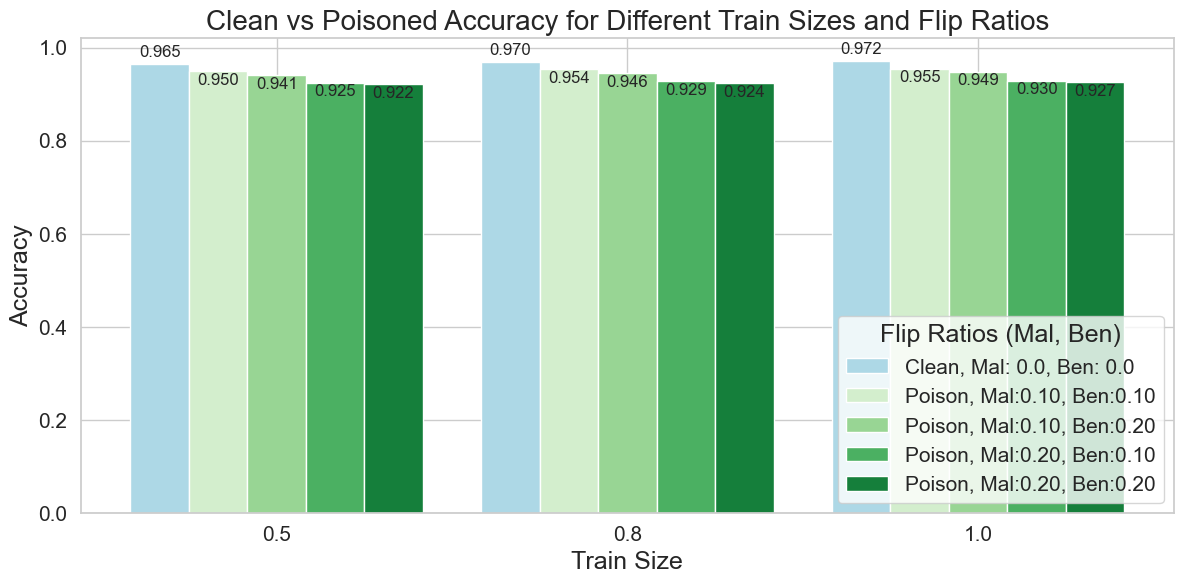

In [30]:
###Plotting Accuracy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

            
# Average Accuracy
average_clean_accs = {k: sum(v) / len(v) for k, v in clean_accs.items()}
average_poison_accs = {k: sum(v) / len(v) for k, v in poison_accs.items()}


def plot_grouped_bar_chart(train_sizes, flip_ratios_mal, flip_ratios_ben, average_clean_accs, average_poison_accs):
    num_groups = len(flip_ratios_mal) * len(flip_ratios_ben)
    ind = np.arange(len(train_sizes))
    width = 1 / (num_groups + 2)

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.set(style="whitegrid")

    clean_color = '#ADD8E6'
    poison_colors = sns.color_palette("Greens", num_groups)

    for i, train_size in enumerate(train_sizes):
        clean_acc = average_clean_accs[(train_size, flip_ratios_mal[0], flip_ratios_ben[0])]
        #rects_clean = ax.bar(ind[i], clean_acc, width, color=clean_color, label=f'Clean' if i == 0 else None)
        rects_clean = ax.bar(ind[i], clean_acc, width, color=clean_color, label=f'Clean, Mal: 0.0, Ben: 0.0' if i == 0 else None)

        ax.annotate(f'{clean_acc:.3f}', xy=(rects_clean[0].get_x() + rects_clean[0].get_width() / 2, clean_acc),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)

    for i, (flip_ratio_mal, flip_ratio_ben) in enumerate([(frm, frb) for frm in flip_ratios_mal for frb in flip_ratios_ben]):
        poison_acc = [average_poison_accs[(train_size, flip_ratio_mal, flip_ratio_ben)] for train_size in train_sizes]

        rects_poison = ax.bar(ind + (i + 1) * width, poison_acc, width, color=poison_colors[i], label=f'Poison, Mal:{flip_ratio_mal:.2f}, Ben:{flip_ratio_ben:.2f}')

        for rect, acc in zip(rects_poison, poison_acc):
            ax.annotate(f'{acc:.3f}', xy=(rect.get_x() + rect.get_width() / 2, acc),
                        xytext=(0, -12), textcoords="offset points", ha='center', va='bottom', fontsize=12)

    ax.set_xlabel('Train Size', fontsize=18)
    ax.set_ylabel('Accuracy', fontsize=18)
    ax.set_title('Clean vs Poisoned Accuracy for Different Train Sizes and Flip Ratios', fontsize=20)
    ax.set_xticks(ind + num_groups * width / 2)
    ax.set_xticklabels([f'{train_size:.1f}' for train_size in train_sizes])
    ax.legend(loc ="lower right", bbox_to_anchor=(1, 0), title='Flip Ratios (Mal, Ben)', title_fontsize=18, fontsize=15)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig("../figures/exp2/exp2_acc.pdf")
    plt.show()

plot_grouped_bar_chart(train_sizes, flip_ratios_mal, flip_ratios_ben, average_clean_accs, average_poison_accs)


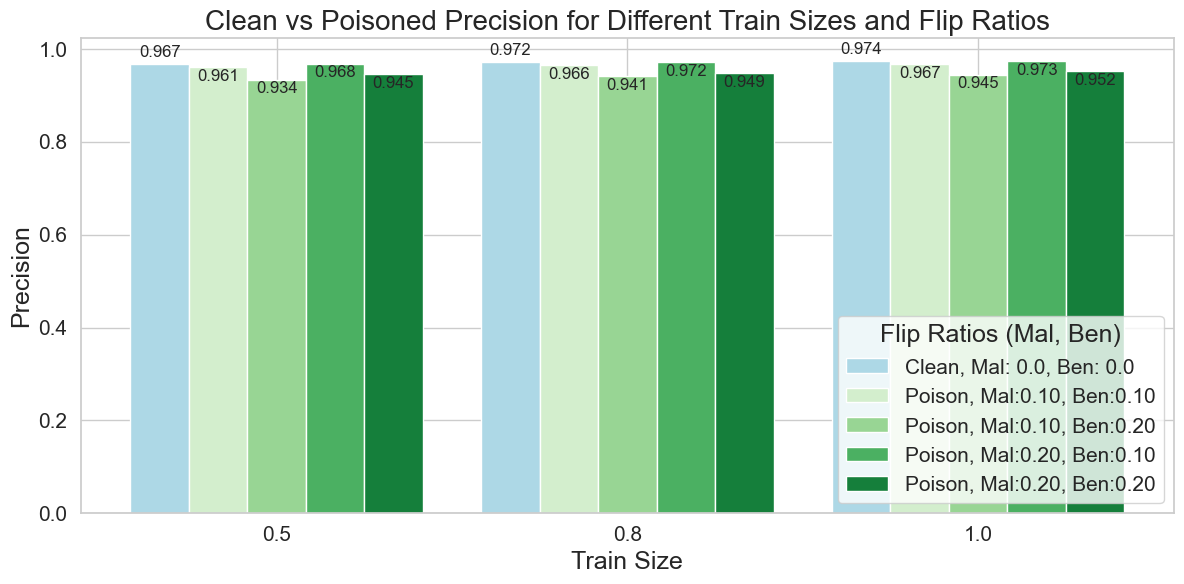

In [31]:
# plotting precision

# average precision
average_clean_precision = {k: sum(perf['precision_clean'] for perf in performance if (perf['train_size'], perf['flip_ratio_mal'], perf['flip_ratio_ben']) == k) / len(v)
                           for k, v in clean_accs.items()}
average_poison_precision = {k: sum(perf['precision_poison'] for perf in performance if (perf['train_size'], perf['flip_ratio_mal'], perf['flip_ratio_ben']) == k) / len(v)
                            for k, v in poison_accs.items()}
#print("Average Clean Precision:", average_clean_precision)
#print("Average Poison Precision:", average_poison_precision)

def plot_grouped_bar_chart_precision(train_sizes, flip_ratios_mal, flip_ratios_ben, average_clean_precision, average_poison_precision):
    num_groups = len(flip_ratios_mal) * len(flip_ratios_ben)
    ind = np.arange(len(train_sizes))
    width = 1 / (num_groups + 2)

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.set(style="whitegrid")

    clean_color = '#ADD8E6'
    poison_colors = sns.color_palette("Greens", num_groups)

    for i, train_size in enumerate(train_sizes):
        clean_precision = average_clean_precision[(train_size, flip_ratios_mal[0], flip_ratios_ben[0])]
        #rects_clean = ax.bar(ind[i], clean_precision, width, color=clean_color, label=f'Clean' if i == 0 else None)
        rects_clean = ax.bar(ind[i], clean_precision, width, color=clean_color, label=f'Clean, Mal: 0.0, Ben: 0.0' if i == 0 else None)

        ax.annotate(f'{clean_precision:.3f}', xy=(rects_clean[0].get_x() + rects_clean[0].get_width() / 2, clean_precision),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)

    for i, (flip_ratio_mal, flip_ratio_ben) in enumerate([(frm, frb) for frm in flip_ratios_mal for frb in flip_ratios_ben]):
        poison_precision = [average_poison_precision[(train_size, flip_ratio_mal, flip_ratio_ben)] for train_size in train_sizes]

        rects_poison = ax.bar(ind + (i + 1) * width, poison_precision, width, color=poison_colors[i], label=f'Poison, Mal:{flip_ratio_mal:.2f}, Ben:{flip_ratio_ben:.2f}')

        for rect, precision in zip(rects_poison, poison_precision):
            ax.annotate(f'{precision:.3f}', xy=(rect.get_x() + rect.get_width() / 2, precision),
                        xytext=(0, -12), textcoords="offset points", ha='center', va='bottom', fontsize=12)

    ax.set_xlabel('Train Size', fontsize=18)
    ax.set_ylabel('Precision', fontsize=18)
    ax.set_title('Clean vs Poisoned Precision for Different Train Sizes and Flip Ratios', fontsize=20)
    ax.set_xticks(ind + num_groups * width / 2)
    ax.set_xticklabels([f'{train_size:.1f}' for train_size in train_sizes])
    ax.legend(loc ="lower right", bbox_to_anchor=(1, 0), title='Flip Ratios (Mal, Ben)', title_fontsize=18, fontsize=15)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.tight_layout()
    plt.savefig("../figures/exp2/exp2_precision.pdf")
    plt.show()

plot_grouped_bar_chart_precision(train_sizes, flip_ratios_mal, flip_ratios_ben, average_clean_precision, average_poison_precision)


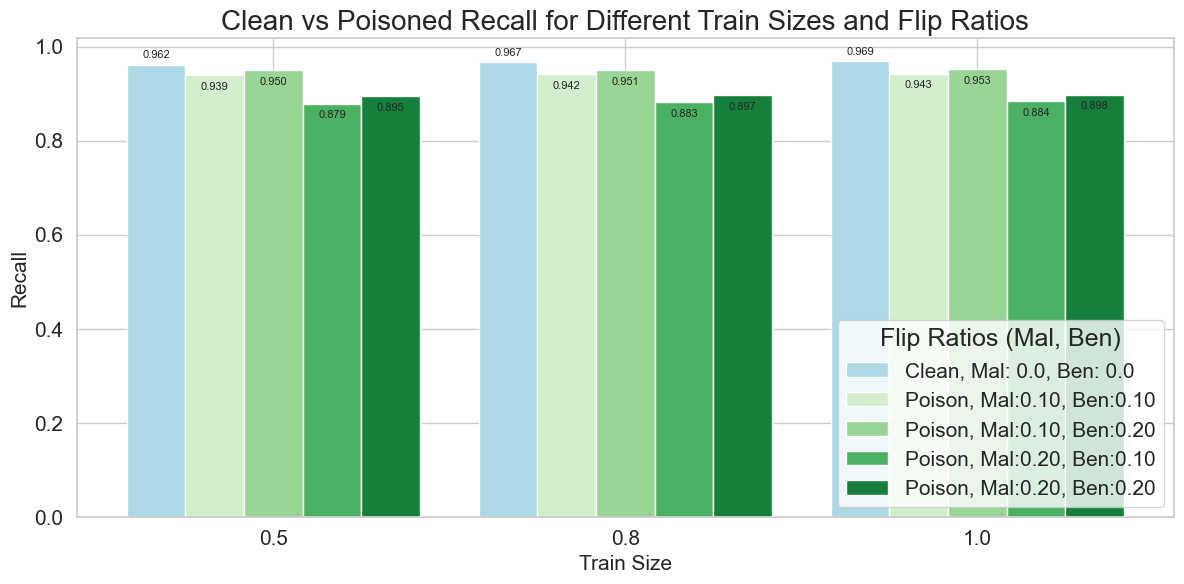

In [32]:
# plotting Recall

# average recall
average_clean_recall = {k: sum(perf['recall_clean'] for perf in performance if (perf['train_size'], perf['flip_ratio_mal'], perf['flip_ratio_ben']) == k) / len([perf for perf in performance if (perf['train_size'], perf['flip_ratio_mal'], perf['flip_ratio_ben']) == k])
                        for k in clean_accs.keys()}
average_poison_recall = {k: sum(perf['recall_poison'] for perf in performance if (perf['train_size'], perf['flip_ratio_mal'], perf['flip_ratio_ben']) == k) / len([perf for perf in performance if (perf['train_size'], perf['flip_ratio_mal'], perf['flip_ratio_ben']) == k])
                         for k in poison_accs.keys()}
#print("Average Clean Recall:", average_clean_recall)
#print("Average Poison Recall:", average_poison_recall)

def plot_grouped_bar_chart_recall(train_sizes, flip_ratios_mal, flip_ratios_ben, average_clean_recall, average_poison_recall):
    num_groups = len(flip_ratios_mal) * len(flip_ratios_ben)
    ind = np.arange(len(train_sizes))
    width = 1 / (num_groups + 2)

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.set(style="whitegrid")

    clean_color = '#ADD8E6'
    poison_colors = sns.color_palette("Greens", num_groups)

    for i, train_size in enumerate(train_sizes):
        clean_recall = average_clean_recall[(train_size, flip_ratios_mal[0], flip_ratios_ben[0])]
        #rects_clean = ax.bar(ind[i], clean_recall, width, color=clean_color, label=f'Clean' if i == 0 else None)
        rects_clean = ax.bar(ind[i], clean_recall, width, color=clean_color, label=f'Clean, Mal: 0.0, Ben: 0.0' if i == 0 else None)

        ax.annotate(f'{clean_recall:.3f}', xy=(rects_clean[0].get_x() + rects_clean[0].get_width() / 2, clean_recall),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

    for i, (flip_ratio_mal, flip_ratio_ben) in enumerate([(frm, frb) for frm in flip_ratios_mal for frb in flip_ratios_ben]):
        poison_recall = [average_poison_recall[(train_size, flip_ratio_mal, flip_ratio_ben)] for train_size in train_sizes]

        rects_poison = ax.bar(ind + (i + 1) * width, poison_recall, width, color=poison_colors[i], label=f'Poison, Mal:{flip_ratio_mal:.2f}, Ben:{flip_ratio_ben:.2f}')

        for rect, recall in zip(rects_poison, poison_recall):
            ax.annotate(f'{recall:.3f}', xy=(rect.get_x() + rect.get_width() / 2, recall),
                        xytext=(0, -12), textcoords="offset points", ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Train Size', fontsize=15)
    ax.set_ylabel('Recall', fontsize=15)
    ax.set_title('Clean vs Poisoned Recall for Different Train Sizes and Flip Ratios', fontsize=20)
    ax.set_xticks(ind + num_groups * width / 2)
    ax.set_xticklabels([f'{train_size:.1f}' for train_size in train_sizes])
    ax.legend(loc ="lower right", bbox_to_anchor=(1, 0), title='Flip Ratios (Mal, Ben)', title_fontsize=18, fontsize=15)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig("../figures/exp2/exp2_recall.pdf")
    plt.show()

plot_grouped_bar_chart_recall(train_sizes, flip_ratios_mal, flip_ratios_ben, average_clean_recall, average_poison_recall)



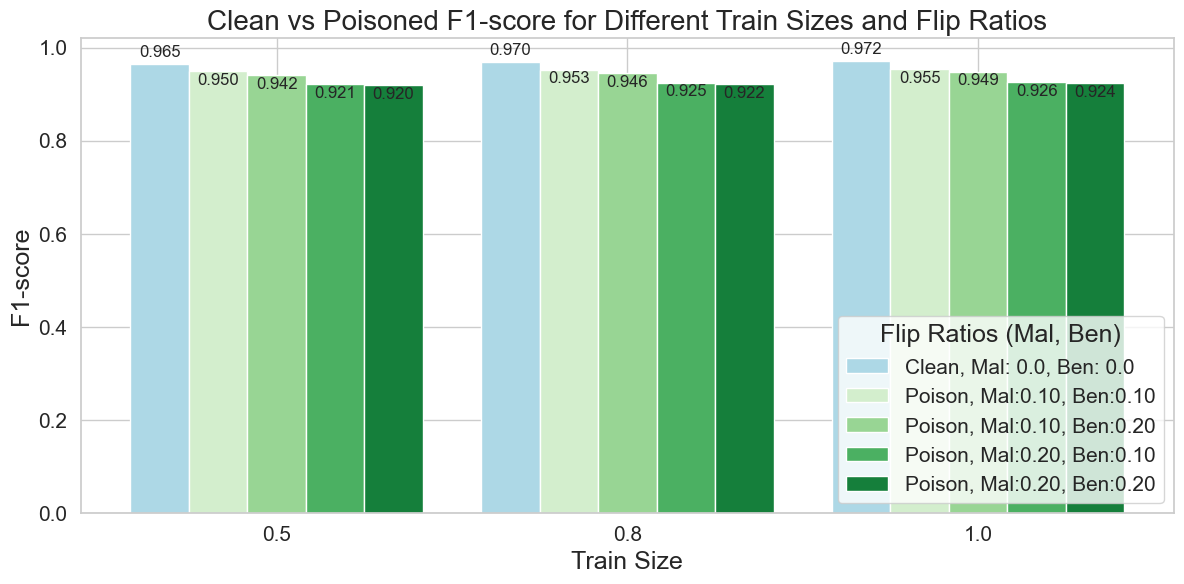

In [33]:
###Plotting F1 scores

# Calculate average F1 scores
average_clean_f1 = {k: sum(perf['f1_clean'] for perf in performance if (perf['train_size'], perf['flip_ratio_mal'], perf['flip_ratio_ben']) == k) / len(v)
                   for k, v in clean_accs.items()}
average_poison_f1 = {k: sum(perf['f1_poison'] for perf in performance if (perf['train_size'], perf['flip_ratio_mal'], perf['flip_ratio_ben']) == k) / len(v)
                   for k, v in poison_accs.items()}

def plot_grouped_bar_chart_f1(train_sizes, flip_ratios_mal, flip_ratios_ben, average_clean_f1, average_poison_f1):
    num_groups = len(flip_ratios_mal) * len(flip_ratios_ben)
    ind = np.arange(len(train_sizes))
    width = 1 / (num_groups + 2)

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.set(style="whitegrid")

    clean_color = '#ADD8E6'
    poison_colors = sns.color_palette("Greens", num_groups)

    for i, train_size in enumerate(train_sizes):
        clean_f1 = average_clean_f1[(train_size, flip_ratios_mal[0], flip_ratios_ben[0])]
        #rects_clean = ax.bar(ind[i], clean_f1, width, color=clean_color, label=f'Clean' if i == 0 else None)
        rects_clean = ax.bar(ind[i], clean_f1, width, color=clean_color, label=f'Clean, Mal: 0.0, Ben: 0.0' if i == 0 else None)

        ax.annotate(f'{clean_f1:.3f}', xy=(rects_clean[0].get_x() + rects_clean[0].get_width() / 2, clean_f1),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)

    for i, (flip_ratio_mal, flip_ratio_ben) in enumerate([(frm, frb) for frm in flip_ratios_mal for frb in flip_ratios_ben]):
        poison_f1 = [average_poison_f1[(train_size, flip_ratio_mal, flip_ratio_ben)] for train_size in train_sizes]

        rects_poison = ax.bar(ind + (i + 1) * width, poison_f1, width, color=poison_colors[i], label=f'Poison, Mal:{flip_ratio_mal:.2f}, Ben:{flip_ratio_ben:.2f}')

        for rect, f1 in zip(rects_poison, poison_f1):
            ax.annotate(f'{f1:.3f}', xy=(rect.get_x() + rect.get_width() / 2, f1),
                        xytext=(0, -12), textcoords="offset points", ha='center', va='bottom', fontsize=12)

    ax.set_xlabel('Train Size', fontsize=18)
    ax.set_ylabel('F1-score', fontsize=18)
    ax.set_title('Clean vs Poisoned F1-score for Different Train Sizes and Flip Ratios', fontsize=20)
    ax.set_xticks(ind + num_groups * width / 2)
    ax.set_xticklabels([f'{train_size:.1f}' for train_size in train_sizes])
    ax.legend(loc ="lower right", bbox_to_anchor=(1, 0), title='Flip Ratios (Mal, Ben)', title_fontsize=18, fontsize=15)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig("../figures/exp2/exp2_f1.pdf")
    plt.show()

plot_grouped_bar_chart_f1(train_sizes, flip_ratios_mal, flip_ratios_ben, average_clean_f1, average_poison_f1)



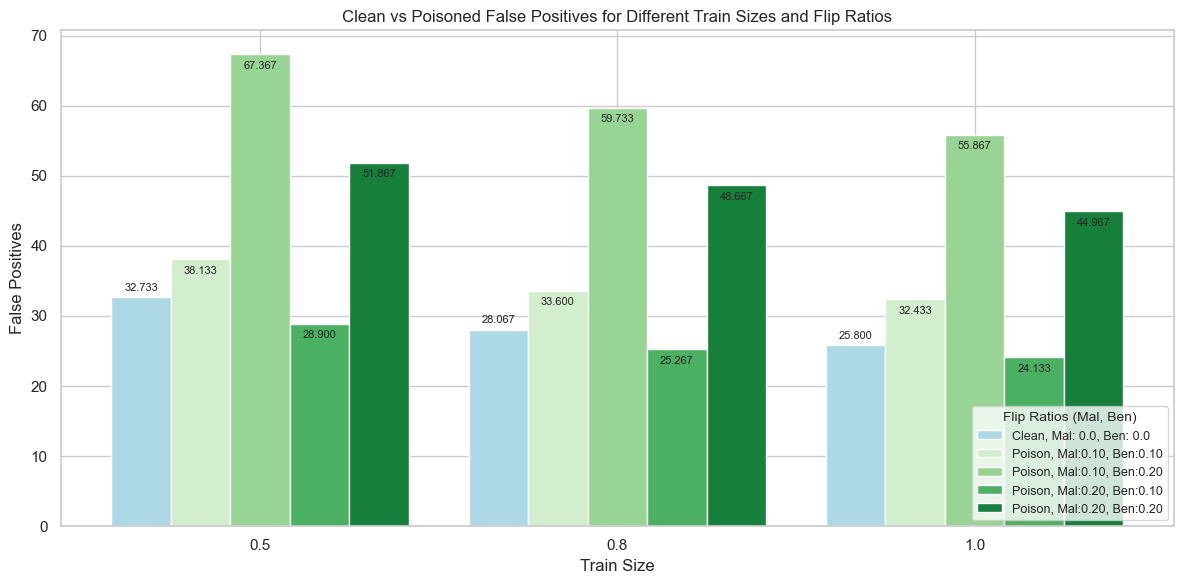

In [34]:
# Add these lines after calculating the clean_accs and poison_accs dictionaries
clean_fps = defaultdict(lambda: [])
poison_fps = defaultdict(lambda: [])

for p in performance:
    clean_fps[(p['train_size'], p['flip_ratio_mal'], p['flip_ratio_ben'])].append(p['fp_clean'])
    poison_fps[(p['train_size'], p['flip_ratio_mal'], p['flip_ratio_ben'])].append(p['fp_poison'])

# Average False Positives
average_clean_fps = {k: sum(v) / len(v) for k, v in clean_fps.items()}
average_poison_fps = {k: sum(v) / len(v) for k, v in poison_fps.items()}

def plot_grouped_bar_chart_fp(train_sizes, flip_ratios_mal, flip_ratios_ben, average_clean_fps, average_poison_fps):
    num_groups = len(flip_ratios_mal) * len(flip_ratios_ben)
    ind = np.arange(len(train_sizes))
    width = 1 / (num_groups + 2)

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.set(style="whitegrid")

    clean_color = '#ADD8E6'
    poison_colors = sns.color_palette("Greens", num_groups)

    for i, train_size in enumerate(train_sizes):
        clean_fp = average_clean_fps[(train_size, flip_ratios_mal[0], flip_ratios_ben[0])]
        rects_clean = ax.bar(ind[i], clean_fp, width, color=clean_color, label=f'Clean, Mal: 0.0, Ben: 0.0' if i == 0 else None)

        ax.annotate(f'{clean_fp:.3f}', xy=(rects_clean[0].get_x() + rects_clean[0].get_width() / 2, clean_fp),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

    for i, (flip_ratio_mal, flip_ratio_ben) in enumerate([(frm, frb) for frm in flip_ratios_mal for frb in flip_ratios_ben]):
        poison_fp = [average_poison_fps[(train_size, flip_ratio_mal, flip_ratio_ben)] for train_size in train_sizes]

        rects_poison = ax.bar(ind + (i + 1) * width, poison_fp, width, color=poison_colors[i], label=f'Poison, Mal:{flip_ratio_mal:.2f}, Ben:{flip_ratio_ben:.2f}')

        for rect, fp in zip(rects_poison, poison_fp):
            ax.annotate(f'{fp:.3f}', xy=(rect.get_x() + rect.get_width() / 2, fp),
                        xytext=(0, -12), textcoords="offset points", ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Train Size')
    ax.set_ylabel('False Positives')
    ax.set_title('Clean vs Poisoned False Positives for Different Train Sizes and Flip Ratios')
    ax.set_xticks(ind + num_groups * width / 2)
    ax.set_xticklabels([f'{train_size:.1f}' for train_size in train_sizes])
    ax.legend(loc='lower right', title='Flip Ratios (Mal, Ben)', title_fontsize=10, fontsize=9)

    # Continued from the previous function
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Call the function
plot_grouped_bar_chart_fp(train_sizes, flip_ratios_mal, flip_ratios_ben, average_clean_fps, average_poison_fps)



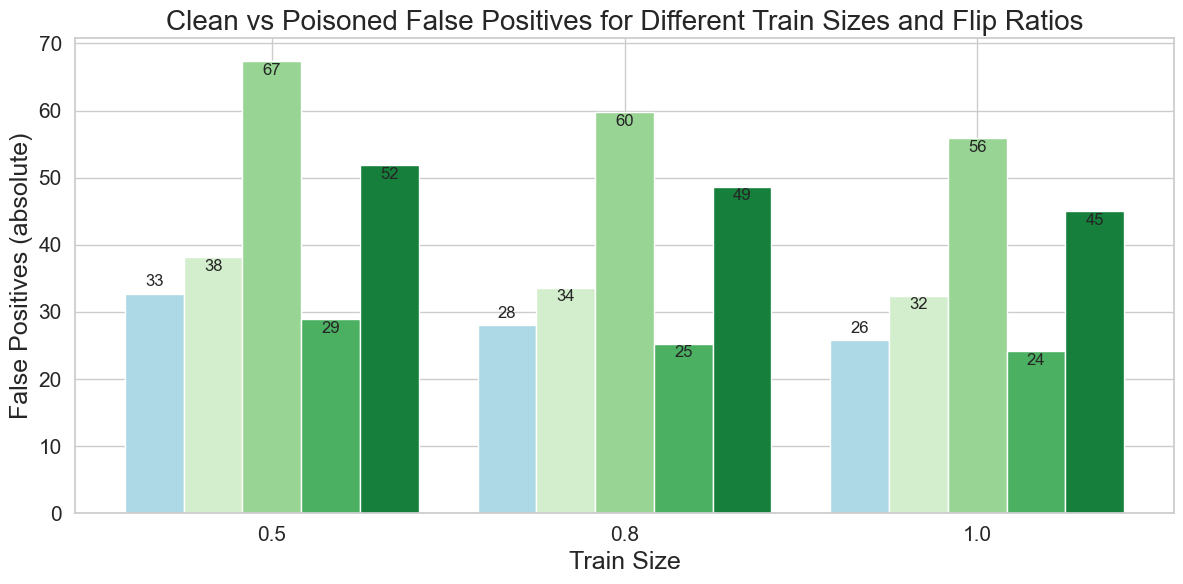

In [35]:
# Add these lines after calculating the clean_accs and poison_accs dictionaries
clean_fps = defaultdict(lambda: [])
poison_fps = defaultdict(lambda: [])

for p in performance:
    clean_fps[(p['train_size'], p['flip_ratio_mal'], p['flip_ratio_ben'])].append(p['fp_clean'])
    poison_fps[(p['train_size'], p['flip_ratio_mal'], p['flip_ratio_ben'])].append(p['fp_poison'])

# Average False Positives
average_clean_fps = {k: sum(v) / len(v) for k, v in clean_fps.items()}
average_poison_fps = {k: sum(v) / len(v) for k, v in poison_fps.items()}

def plot_grouped_bar_chart_fp(train_sizes, flip_ratios_mal, flip_ratios_ben, average_clean_fps, average_poison_fps):
    num_groups = len(flip_ratios_mal) * len(flip_ratios_ben)
    ind = np.arange(len(train_sizes))
    width = 1 / (num_groups + 2)

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.set(style="whitegrid")

    clean_color = '#ADD8E6'
    poison_colors = sns.color_palette("Greens", num_groups)

    for i, train_size in enumerate(train_sizes):
        clean_fp = average_clean_fps[(train_size, flip_ratios_mal[0], flip_ratios_ben[0])]
        rects_clean = ax.bar(ind[i], clean_fp, width, color=clean_color, label=f'Clean, Mal: 0.0, Ben: 0.0' if i == 0 else None)

        ax.annotate(f'{clean_fp:.0f}', xy=(rects_clean[0].get_x() + rects_clean[0].get_width() / 2, clean_fp),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)

    for i, (flip_ratio_mal, flip_ratio_ben) in enumerate([(frm, frb) for frm in flip_ratios_mal for frb in flip_ratios_ben]):
        poison_fp = [average_poison_fps[(train_size, flip_ratio_mal, flip_ratio_ben)] for train_size in train_sizes]

        rects_poison = ax.bar(ind + (i + 1) * width, poison_fp, width, color=poison_colors[i], label=f'Poison, Mal:{flip_ratio_mal:.2f}, Ben:{flip_ratio_ben:.2f}')

        for rect, fp in zip(rects_poison, poison_fp):
            ax.annotate(f'{fp:.0f}', xy=(rect.get_x() + rect.get_width() / 2, fp),
                        xytext=(0, -12), textcoords="offset points", ha='center', va='bottom', fontsize=12)

    ax.set_xlabel('Train Size', fontsize=18)
    ax.set_ylabel('False Positives (absolute)', fontsize=18)
    ax.set_title('Clean vs Poisoned False Positives for Different Train Sizes and Flip Ratios', fontsize=20)
    ax.set_xticks(ind + num_groups * width / 2)
    ax.set_xticklabels([f'{train_size:.1f}' for train_size in train_sizes])
    #ax.legend(loc ="lower right", bbox_to_anchor=(1, 0), title='Flip Ratios (Mal, Ben)', title_fontsize=18, fontsize=15)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.tight_layout()
    plt.grid(True)
    plt.savefig("../figures/exp2/exp2_fpr.pdf")
    plt.show()

# Call the function
plot_grouped_bar_chart_fp(train_sizes, flip_ratios_mal, flip_ratios_ben, average_clean_fps, average_poison_fps)



In [36]:
#### SAVING RESULTS

import pickle
results_folder = "../results/exp2/"

## Results
with open(results_folder + 'performance.pkl', 'wb') as f:
    pickle.dump(performance, f)
    
## Support (just for complete reproducibility)
with open(results_folder + 'train_sizes.pkl', 'wb') as f:
    pickle.dump(train_sizes, f)

with open(results_folder + 'flip_ratios_mal.pkl', 'wb') as f:
    pickle.dump(flip_ratios_mal, f)
    
with open(results_folder + 'flip_ratios_ben.pkl', 'wb') as f:
    pickle.dump(flip_ratios_ben, f)

## DATA
with open(results_folder + 'mal.pkl', 'wb') as f:
    pickle.dump(df_mal, f)
    
with open(results_folder + 'ben.pkl', 'wb') as f:
    pickle.dump(df_ben, f)

In [37]:
## TWO SAMPLE T TEST

## Selecting samples
ts = 1.0
frm = 0.2
frb = 0.2

f1_clean = list()
f1_poison = list()

for p in performance:
    if p['train_size'] == ts and p['flip_ratio_mal']==frm and p['flip_ratio_ben']==frb:
        f1_clean.append(p['f1_clean'])
        f1_poison.append(p['f1_poison'])

## Transforming in arrays
f1c = np.array(f1_clean)
f1p = np.array(f1_poison)

## Printing mean and std
print(f1c.mean(), f1c.std())
print(f1p.mean(), f1p.std())

## Calculating statistic
from scipy import stats as st
st.ttest_ind(a=f1p, b=f1c, equal_var=True)

0.9716447200365997 0.003867696438479046
0.9244563817840109 0.006329310873636688


Ttest_indResult(statistic=-34.259130978743336, pvalue=3.4943136512250952e-40)